# Method1 SVD+Huffman

### Code

#### Import the EDF file
Installation: https://mne.tools/dev/install/mne_python.html

Function description: https://mne.tools/dev/generated/mne.io.read_raw_edf.html

In [3]:
import mne
file = "/Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/Baiying/ECG.EDF"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()
# you can get the metadata included in the file and a list of all channels:
info = data.info
channels = data.ch_names

Extracting EDF parameters from /Users/lubaiying/Desktop/big_ideas_lab/DBDP_Compression_Toolbox/Baiying/ECG.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [5]:
info

<Info | 7 non-empty values
 bads: []
 ch_names: ECG, Marker, HRV
 chs: 3 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2019-07-23 12:16:57 UTC
 nchan: 3
 projs: []
 sfreq: 1000.0 Hz
>

#### Convert the edf file into csv and reload the csv file

In [9]:
import numpy as np
header = ','.join(data.ch_names)
np.savetxt('ECG.csv', data.get_data().T, delimiter=',', header=header)

In [15]:
import pandas as pd
ecg = pd.read_csv('ECG.csv')

In [16]:
ecg

,# ECG,Marker,HRV
0,0.032767,0.0,0.0
1,0.032767,0.0,0.0
2,0.032767,0.0,0.0
3,0.032767,0.0,0.0
4,0.032767,0.0,0.0
...,...,...,...
3269995,0.002334,0.0,0.0
3269996,0.002037,0.0,0.0
3269997,0.001726,0.0,0.0
3269998,0.001404,0.0,0.0


#### Plot the signal to explore the data

In [17]:
index = np.linspace(0, 3269.999, 3270000)
index

array([0.000000e+00, 1.000000e-03, 2.000000e-03, ..., 3.269997e+03,
       3.269998e+03, 3.269999e+03])

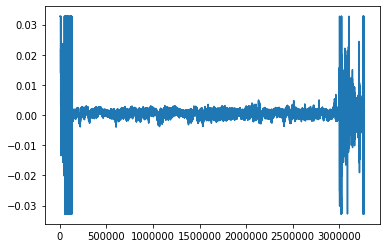

In [18]:
ecg["# ECG"].plot()

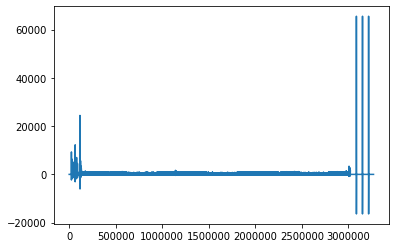

In [19]:
ecg["HRV"].plot()

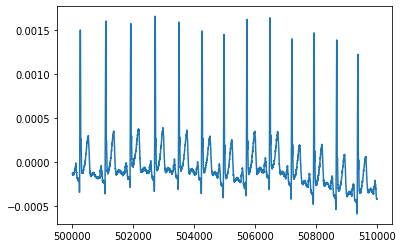

In [31]:
ECG_example = ecg["# ECG"][500000:510000]
ECG_example.plot()

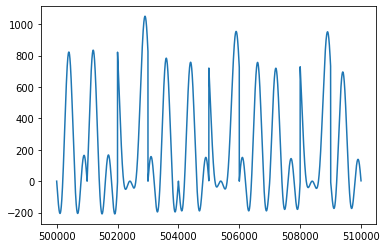

In [32]:
HRV_example = ecg["HRV"][500000:510000]
HRV_example.plot()

### Instructions

Put instructions of how to use your method here.

Dependencies:

### Evaluation

The results of this method on the following wearable sensors:

| Wearable Sensor | Compression Ratio | Percentage RMS difference |
| ------ | ------ | ------ | 
| ECG | XX | XX |
| PPG | XX | XX |
| ACC | XX | XX |
| EDA | XX | XX |
| TEMP | XX | XX |